In [1]:
#!/usr/bin/env python

In [2]:
import os
import sys
if os.path.exists('/home/chieh/code/wPlotLib'):
	sys.path.insert(0,'/home/chieh/code/wPlotLib')
if os.path.exists('/home/chieh/code/wuML'):
	sys.path.insert(0,'/home/chieh/code/wuML')

In [3]:
import wuml
import numpy as np
import torch
import torch
import torch.nn as nn

In [4]:
def costFunction(x, x̂, ẙ, y, ŷ, ind):	
#	x -> encoder -> x̂
#	x̂ -> encoder_linear_output -> ẙ	
#	x̂ -> decoder -> ŷ	
#	possible autoencoder objective λ could be 0
#	loss = (x - ŷ)ᒾ + λ * objective(ẙ, y)
#
#	This function can return 1 value or 3 values in a list
#	if return 1 value, just the loss
#	if return 3 values, [total_loss, reconstruction_loss, extra network from ẙ loss]
#
#	In this example, we perform both reconstruction and CE loss
#
	CE_loss = nn.CrossEntropyLoss() #weird pytorch, dim of y is 1, and ŷ is 20x3
	R = torch.sum((x - ŷ) ** 2)/(128*13)	#scaled by batch size times data dimension
	mse = torch.sum((ẙ - y) ** 2)/(128)	#scaled by batch size times data dimension
	loss = R + mse
	return [loss, R, mse]

In [5]:
def costFunction2(x, x̂, ẙ, y, ŷ, ind):	
#	Example of just return 1 value, this is just a regular autoencoder
	return torch.sum((x - ŷ) ** 2)

In [6]:
data = wuml.wData('../../data/shap_regress_example_uniform.csv', label_column_name='label', label_type='continuous', 
				preprocess_data='center and scale',	first_row_is_label=True)

In [7]:
[X_train, X_test, y_train, y_test] = wuml.split_training_test(data, test_percentage=0.2)

In [8]:
AE = wuml.autoencoder(12, X_train, default_depth=2, costFunction=costFunction, # costFunction and costFunction2 both works
						max_epoch=1000, encoder_output_weight_structure=[(1,'none')] ) 
AE.fit()

	epoch: 1000, Total Loss/dimension: 0.6015, Reconstruct loss: 0.0136, Objective loss: 0.5879, Learning Rate: 0.00000049

Result of the data reconstruction

In [9]:
ŷ = AE(data)
wuml.jupyter_print('\n\n')
recontructed = wuml.pretty_np_array(ŷ[0:5,0:5], front_tab='', title='recontruction')
original = wuml.pretty_np_array(data.X[0:5,0:5], front_tab=' ', title='original')
wuml.block_two_string_concatenate(recontructed, original, spacing='\t', auto_print=True)

This is the bottleneck output which is d=12

In [10]:
x̂ = AE.reduce_dimension(data, output_type='wData')
wuml.jupyter_print(x̂)
wuml.jupyter_print('\n')

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.374133,-0.139243,0.068916,-0.360120,0.039960,0.517544,-0.226713,0.520601,-0.273546,-0.399290,-0.734112,-0.569699
1,-0.900236,-1.111333,-0.567846,-1.400674,-0.053165,0.248496,0.296838,0.235051,-0.505845,-0.648537,-1.712929,0.076128
2,0.227435,-0.391898,1.187675,-0.424313,-0.444254,-0.557973,-0.500425,-0.015134,0.038139,0.308603,0.201119,-0.571211
3,0.996158,1.637567,-0.467725,0.775716,0.002332,1.094623,-0.506751,1.175113,-0.181533,0.417281,0.421068,-0.968858
4,-2.115170,-1.334415,-0.801267,-1.201678,0.702859,1.211628,0.337728,0.565057,-0.810093,-1.724572,-2.508541,-0.198232
...,...,...,...,...,...,...,...,...,...,...,...,...
25,-0.886250,-1.881234,0.417130,-1.765054,-0.297090,-0.732737,0.189928,-0.376175,-0.397858,-0.309359,-1.209427,0.207707
26,-1.012426,-0.781777,-0.367380,-0.757202,0.463603,0.648107,0.082675,0.443687,-0.715982,-0.672238,-1.062266,-0.288909
27,-1.239528,-0.646718,-1.004983,-1.026330,0.252446,1.091599,0.271887,0.691842,-0.547177,-1.198688,-2.213171,-0.189557
28,-0.155989,-0.545671,0.936492,-0.345757,0.031790,-0.247883,-0.404473,0.076509,-0.316580,0.146016,0.281611,-0.569707


This is the objective network output Training error

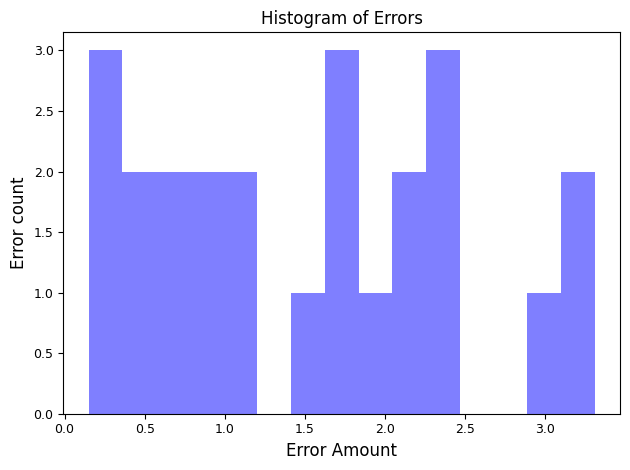

In [11]:
ẙ = AE.objective_network(X_train)
res = wuml.output_regression_result(y_train, ẙ, sort_by='error')

This is the objective network output Test error

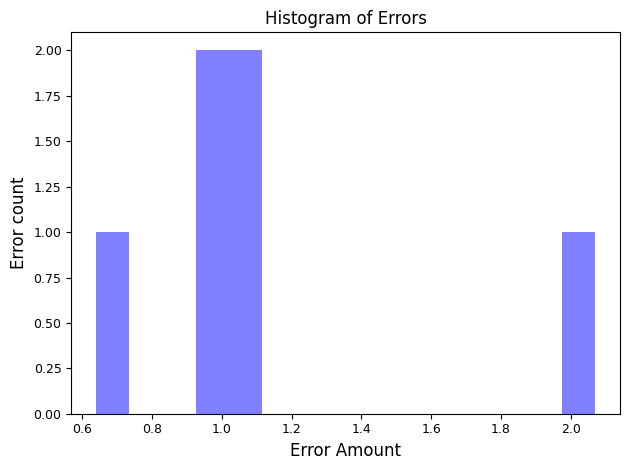

In [12]:
ẙ = AE.objective_network(X_test)
res = wuml.output_regression_result(y_test, ẙ, sort_by='error')